<a href="https://colab.research.google.com/github/EmmanuelABonsu/CE888/blob/main/src/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras import models, layers, optimizers 
import matplotlib.pyplot as plt


In [27]:
# Defining file paths. Model data is stored in Google drive
train_path = "drive/MyDrive/CE888_data/Training"
test_path = "drive/MyDrive/CE888_data/Test"
img_dimension = (254, 254)

In [28]:
# Implemeneted generator to read in image files. This generator is only used for visualization
train_image_gen_visual = ImageDataGenerator(rescale=1./255)                                 
test_image_gen_visual = ImageDataGenerator(rescale=1./255)
preprocessing_train_generator = train_image_gen_visual.flow_from_directory(train_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')
preprocessing_test_generator = test_image_gen_visual.flow_from_directory(test_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [29]:
def show_sample_images(generator, image_title):
  fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(25,4))
  for i, ax in enumerate(axs.flatten()):
      img, label = generator.next()
      plt.sca(ax)
      plt.imshow(img[0])
      plt.title('Image: {}'.format(i+1))
  plt.suptitle(image_title)
  plt.show()

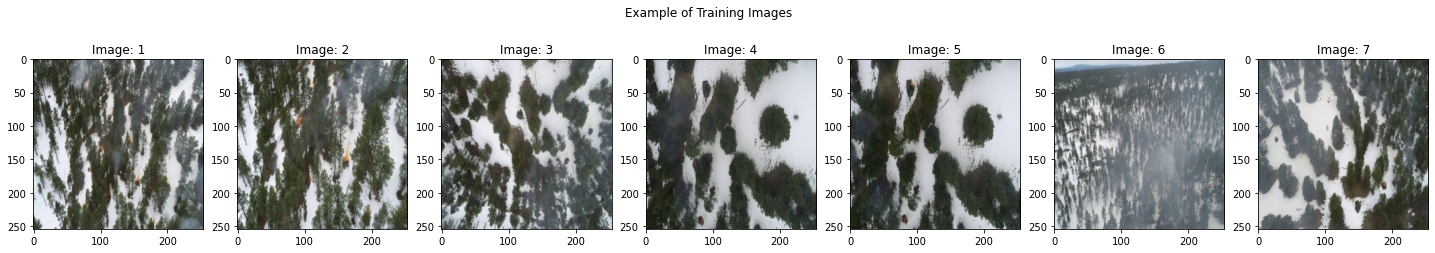

In [30]:
# Displaying example images from train dataset 
show_sample_images(preprocessing_train_generator, "Example of Training Images")

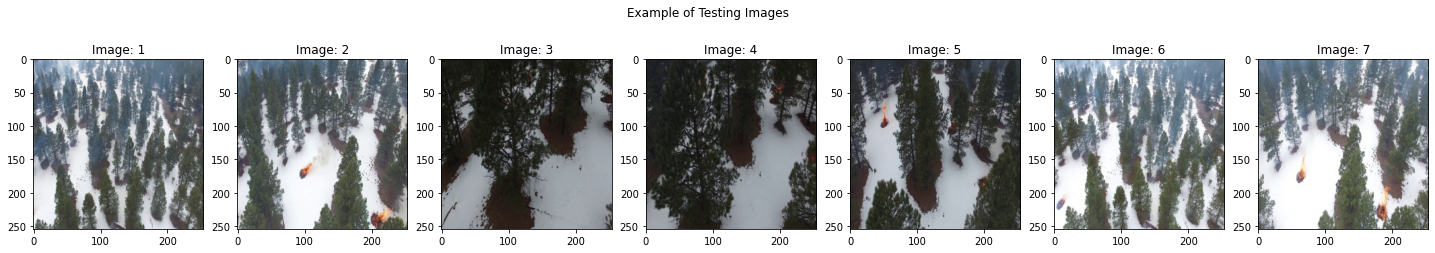

In [31]:
# Displaying example images from test dataset
show_sample_images(preprocessing_test_generator, "Example of Testing Images")

In [32]:
# Load Pre-trained CNN
pre_trained_model = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(254, 254, 3)
)
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 254, 254, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 254, 254, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

In [33]:
# Building Custom model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

pre_trained_model.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4), 
             metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator, epochs=1, 
                    validation_data=validation_generator)

451/985 [============>.................] - ETA: 3:04:16 - loss: 0.1431 - acc: 0.9538

In [ ]:
test_image_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_image_gen.flow_from_directory(
    test_path,
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary')
    

In [ ]:
# Predicting the images from the first batch 
img, label = test_generator[0] 
pred = np.round(model.predict(img)).flatten()

In [ ]:
 Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)